<a href="https://colab.research.google.com/github/AVJdataminer/content_dev/blob/master/Challenge_Time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge: Time series analysis Checkpoint 5

## Instructions

The time series curriculum [checkpoint 6 instructions can be found here for reference.](https://courses.thinkful.com/dsbc-time-series-v1/checkpoint/6)

In this checkpoint we will load a stock price dataset and perform the following tasks: 

- Plot the time series, along with any logical or necessary differences to get a stationary dataset.
- Generate and interpret a PACF for the time series (and/or its differences).
- Generate five ARIMA specifications and evaluate their efficacy at modeling your data.
- Finally, choose one specification and make a case for it as a logical model for your dataset.

In this checkpoint we will test multiple different Arima models and use the RMSE to determine the best model.

1. Load the data and convert to a series. The data is a series of daily stock data from Nvidia from `07/15/2020 - 09/15/2020`, using a an api download from the [Alpaca Api tool](https://algotrading101.com/learn/alpaca-trading-api-guide/).
2. Define a function to apply the arima model with a set of given parameters and set the train_size to 70% of the data.

3. Define a function to iterate over the range of p,d,q values input from testing and generate RMSE scores for each model.
4. Set `p_values`,`d_values`, and `q_values` to range from 0 to 3.
5. Iterate over the parameter values
6. Identify and apply the best set of parameters for the Arima
7. Plot the data against the predictions and the forecast for 14 days out past `09/15/2020`.

8. Check out the Python module: [pmdarima: ARIMA estimators for Python](https://alkaline-ml.com/pmdarima/quickstart.html) which implements similar automation of ARIMA parameterizations.

## Load relevant libraries

In [3]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
np.random.seed(12345)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pylab as plt
%matplotlib inline

## Load the data

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/AVJdataminer/content_dev/master/data/daily_nvda.csv')
# load dataset as the closing price series
series = df.close

In [5]:
df.head()

,timestamp,open,high,low,close,volume,vwap
0,2020-07-15 00:00:00-04:00,416.57,417.3200,402.2300,409.09,10099623.0,409.3327
1,2020-07-16 00:00:00-04:00,400.60,408.2699,395.8200,405.39,8624118.0,402.2828
2,2020-07-17 00:00:00-04:00,409.02,409.9400,403.5101,408.06,6657116.0,407.3048
3,2020-07-20 00:00:00-04:00,410.97,421.2500,406.2700,420.43,7121271.0,415.4516
4,2020-07-21 00:00:00-04:00,420.52,422.3971,411.4700,413.14,6941671.0,415.3402


Let's check out the data types of our columns.

In [6]:
df.dtypes

timestamp     object
open         float64
high         float64
low          float64
close        float64
volume       float64
vwap         float64
dtype: object

Check whether there are any null values. 

In [7]:
df.isnull().values.any()

False

## Create a Date column from the Timestamp

In [8]:
def time_stamp(df):
    df["date"] = pd.to_datetime(df["timestamp"])
    df["date"] = df["date"].dt.date
time_stamp(df)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  44 non-null     object 
 1   open       44 non-null     float64
 2   high       44 non-null     float64
 3   low        44 non-null     float64
 4   close      44 non-null     float64
 5   volume     44 non-null     float64
 6   vwap       44 non-null     float64
 7   date       44 non-null     object 
dtypes: float64(6), object(2)
memory usage: 2.9+ KB


## Plot the data

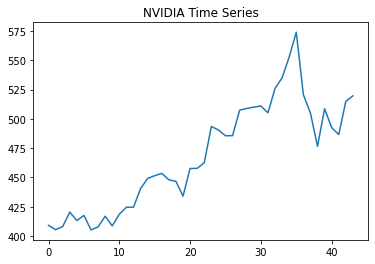

In [10]:
# series plot
df.close.plot()
plt.title('NVIDIA Time Series')
plt.show()

## Create a Difference column and plot it

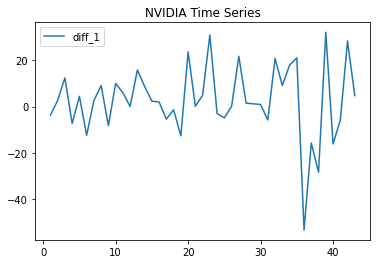

In [11]:
df['diff_1'] = df.close - df.close.shift()
df.plot(y='diff_1')
plt.title('NVIDIA Time Series')
plt.show()

## PACF plot

Text(0.5, 1.0, 'NVIDIA PACF')

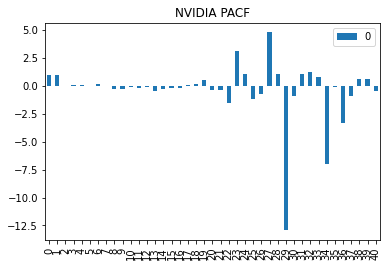

In [12]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(df.close))
x_acf.plot(kind='bar')
plt.title("NVIDIA PACF")

## Difference PACF plot

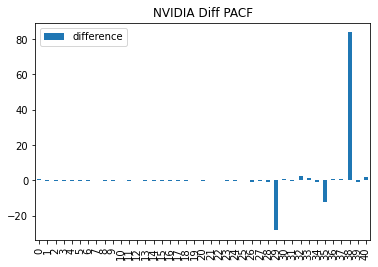

In [13]:
x_acf = pd.DataFrame(pacf(df.diff_1[1:]))
x_acf.plot(kind='bar')
plt.title("NVIDIA Diff PACF")
plt.legend(['difference'])

## The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [15]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

### Make a function to find the MSE of a single ARIMA model.
Use a 70/30 train and test split of the input data.

In [16]:
# Make a function to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    split=int(len(data) * 0.7) 
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

### Make a function to evaluate the different ARIMA models with different p, d, and q values

In [17]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

### Select a range of values for p,d, and q to iterate over.

In [18]:
# Now, we choose a couple of values to try for each parameter.
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

### Run the functions over the dataset

In [20]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
evaluate_models(df.close.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=3100.798
ARIMA(0, 0, 1) MSE=1744.993
ARIMA(0, 1, 0) MSE=776.350
ARIMA(0, 1, 1) MSE=930.438
ARIMA(0, 1, 2) MSE=1150.371
ARIMA(0, 2, 0) MSE=1702.998
ARIMA(0, 2, 1) MSE=866.883
ARIMA(1, 0, 0) MSE=706.610
ARIMA(1, 1, 0) MSE=895.375
ARIMA(1, 2, 0) MSE=1198.933
ARIMA(1, 2, 1) MSE=1003.140
ARIMA(2, 0, 0) MSE=769.921
ARIMA(2, 1, 0) MSE=1062.929
ARIMA(2, 1, 1) MSE=994.450
ARIMA(2, 2, 0) MSE=1266.795
ARIMA(2, 2, 1) MSE=1331.584
Best ARIMA(1, 0, 0) MSE=706.610


So the best p,d, q, parameters for our ARIMA model are 1, 0, 0 respectively. Now we know this, we can build the model.

### Apply the best model

In [ ]:
# Train and test split
X = df.close
X = X.astype('float32')
train_size = int(len(X) * 0.70)
train, test = X[0:train_size], X[train_size:]

# Build Model 
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

We can take a look at a summary of the model this library has built around our data.

In [23]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   44
Model:                     ARMA(1, 0)   Log Likelihood                -184.237
Method:                       css-mle   S.D. of innovations             15.525
Date:                Sun, 04 Oct 2020   AIC                            374.475
Time:                        18:19:00   BIC                            379.827
Sample:                             0   HQIC                           376.460
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        466.3391     32.889     14.179      0.000     401.878     530.800
ar.L1.y        0.9472      0.044     21.712      0.000       0.862       1.033
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0558           +0.0000j            1.0558            0.0000
-----------------------------------------------------------------------------
"""

### Visualize the original dataset plotted against our model. 

<Figure size 1200x500 with 0 Axes>

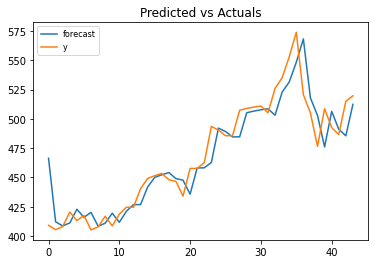

In [70]:
model_fit = model.fit(disp=0)
model_fit.plot_predict(dynamic=False)
plt.title('Predicted vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Forecast the data for 14 days into the future and plot

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast 14 days in to the future.

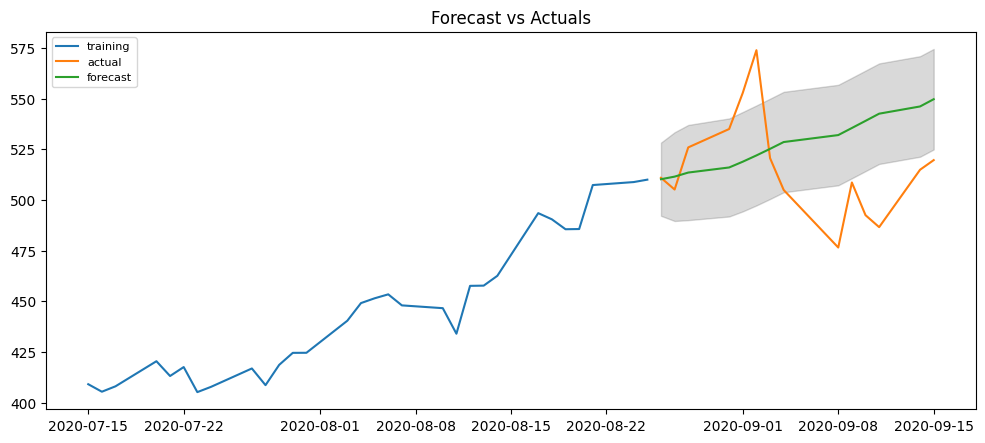

In [67]:
# Builed the Forecast for 14 days into the future
fc, se, conf = fitted.forecast(14, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()